# LC-MS: All Features Neg 


In [32]:
import pandas as pd
import numpy as np
import os
import openpyxl

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt


from itertools import combinations
from sklearn.decomposition import PCA
from scipy.stats import zscore, entropy, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cross_decomposition import CCA


from sklearn.ensemble import IsolationForest

%matplotlib inline

In [33]:
# set the directory 
os.chdir('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results')

In [34]:
# Define the color palette for the sample types
sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

# set SNS style
sns.set_style(style="whitegrid")

# 1. Load data

In [35]:
# order
samples = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/Order_34707_orderitem.csv')

# Extract the list of sample names
sample_names = samples['Sample Name'].tolist()

# Create a new dataframe 'sample_md' with selected column
sample_md = samples[['Sample Name']].copy()
# Split 'Sample Name' into new columns
sample_md[['sample_type', 'year', 'plot']] = sample_md['Sample Name'].str.split('_', expand=True)
sample_md.head()

,Sample Name,sample_type,year,plot
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17


In [36]:
# Get the raw data
file_path = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_ALL_features_NEG.xlsx"

# Read only the 'Area_Stats' sheet
df = pd.read_excel(file_path, sheet_name="Area_Stats")

In [37]:
print('Total Features: ' + str(df.shape[0]))
print('Uniquely annotated features: ' + str(df['Name'].notna().sum()))

Total Features: 5355
Uniquely annotated features: 1389


In [38]:
# Fill empty 'Name' values with 'MW_' + corresponding 'Calc. MW' value
df['Name'] = df['Name'].fillna(df.apply(lambda row: f"mz{row['m/z']:.4f}_RT{row['RT [min]']:.2f}" if pd.notna(row['m/z']) and pd.notna(row['RT [min]']) else "Unknown", axis=1))

## SUBSET TO NORMMALIZED SAMPLES 
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [
    col for col in df.columns
    if any(sample in col for sample in sample_names) and col.startswith('Norm. Area')]# Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df = df[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df.set_index('Name', inplace=True)

df.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
mz232.7640_RT7.24,1.015812e+09,9.591036e+08,9.687200e+08,9.741306e+08,9.110062e+08,9.478149e+08,1.089748e+09,1.068013e+09,9.320766e+08,9.967768e+08,...,6.474207e+08,5.992743e+08,6.773682e+08,5.999018e+08,5.883700e+08,5.724620e+08,6.512763e+08,6.370685e+08,6.499791e+08,6.037124e+08
mz277.0326_RT0.13,2.080220e+08,2.837059e+08,3.444346e+08,2.372584e+08,1.914733e+08,2.889270e+08,3.362667e+08,2.064541e+08,2.506804e+08,1.656926e+08,...,2.492312e+06,8.154455e+06,4.539092e+06,6.589760e+06,3.553400e+07,2.071994e+06,2.666277e+07,3.576882e+06,4.478116e+06,2.081206e+06
mz279.0484_RT0.12,6.377744e+04,9.478871e+04,7.121205e+04,9.973076e+04,8.799896e+04,8.314284e+04,1.270098e+05,9.378965e+04,7.429358e+04,9.956233e+04,...,1.279893e+07,3.110841e+06,4.971845e+06,2.087644e+06,4.367576e+07,9.953229e+05,9.456308e+07,2.175580e+06,1.007542e+07,2.216643e+06
mz354.8437_RT7.20,2.529215e+08,2.442734e+08,2.424406e+08,2.560160e+08,2.131003e+08,2.092058e+08,2.887059e+08,2.678026e+08,2.519748e+08,2.525621e+08,...,1.662585e+08,1.417674e+08,1.735606e+08,1.436585e+08,1.546192e+08,1.525528e+08,1.483458e+08,1.699341e+08,1.625625e+08,1.627462e+08
mz232.7638_RT0.13,1.180974e+07,1.818278e+06,1.501440e+06,1.536287e+06,1.453047e+06,1.458138e+06,1.918847e+06,1.123497e+07,7.771521e+06,2.336688e+06,...,4.795501e+07,1.039781e+07,7.085230e+07,2.404072e+07,5.432684e+06,2.595764e+07,1.423342e+07,1.378458e+07,8.109079e+07,1.489814e+07


In [39]:
## MERGE samples with metadata
df = df.T  # Transpose so samples are rows, features are columns
df.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_wMetadata = sample_md.merge(df, on='Sample Name')

df_wMetadata.head()

,Sample Name,sample_type,year,plot,mz232.7640_RT7.24,mz277.0326_RT0.13,mz279.0484_RT0.12,mz354.8437_RT7.20,mz232.7638_RT0.13,mz352.8469_RT7.20,...,Yersiniabactin,Zeamine II,Zeamine II,Zeamine II,Zearalenone,Zosterin,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,7.446954e+08,2.423256e+06,2.643791e+06,1.679532e+08,8.805396e+06,1.679532e+08,...,2.218193e+06,2.955269e+06,4.604274e+05,200110.393248,8.314012e+05,137080.864179,1.112264e+06,1.507527e+06,358800.378920,6.463435e+07
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,6.994691e+08,2.005486e+06,2.537051e+06,1.497811e+08,1.645117e+07,1.497811e+08,...,2.599382e+05,2.071510e+06,4.458950e+05,234095.318249,1.349134e+06,129874.107159,1.105473e+06,1.318371e+06,442733.713939,4.939247e+07
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,6.853496e+08,2.252984e+06,1.175367e+06,1.689394e+08,3.074711e+07,1.689394e+08,...,3.627925e+05,3.137651e+06,6.221710e+05,173727.629627,9.472279e+05,123888.004350,1.151447e+06,1.836374e+06,359466.563611,1.973607e+07
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,2.405244e+09,5.260993e+05,9.530488e+04,5.880075e+08,6.330130e+07,5.880075e+08,...,2.764654e+06,7.099011e+06,2.617942e+06,645232.448495,4.077015e+06,476398.449270,5.882065e+05,4.863320e+05,979455.842259,1.758999e+05
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,6.597137e+08,2.183757e+06,2.945591e+06,1.602158e+08,7.261743e+06,1.602158e+08,...,1.156300e+06,9.891780e+05,5.009903e+05,180326.913562,1.184830e+06,132489.266857,2.069949e+06,1.219820e+06,347603.303545,8.131816e+07


In [40]:
df_wMetadata.shape

(52, 5359)

In [41]:
# Sum up duplicated Columns: features with the same mz/RT
metadata_columns = ['Sample Name', 'sample_type', 'year', 'plot']

# Separate metadata and data columns
metadata = df_wMetadata[metadata_columns]
data = df_wMetadata.drop(columns=metadata_columns)

# Sum up duplicate columns in the data part
data_summed = data.groupby(data.columns, axis=1).sum()

# Combine metadata and summed data
df_wMetadata = pd.concat([metadata, data_summed], axis=1)

df_wMetadata.shape

/scratch/lfloerl/tmpdata/ipykernel_2446331/1636856459.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_summed = data.groupby(data.columns, axis=1).sum()


(52, 5068)

In [42]:
df_wMetadata.head()

,Sample Name,sample_type,year,plot,(+)-abscisic acid beta-D-glucopyranosyl ester,(+)-applanatumol Z5,(+)-daeschol A,(+)-discoipyrrole A,(+)-pestalachloride E,(+/-)-Gingerol,...,tipifarnib,"trans,trans-Muconic acid",trans-Aconitic acid,trichloroacetate anion,tropatepine,vincofos,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,783785.124454,6.549559e+05,121522.935182,137325.385628,2.531708e+07,3.075984e+07,...,291566.602100,1.191932e+06,8.492033e+07,114730.860287,624310.551197,1.396573e+06,1.112264e+06,1.507527e+06,358800.378920,6.463435e+07
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9,141159.349488,7.808954e+05,188463.905654,142846.141138,3.196022e+07,2.588107e+07,...,299672.082764,1.184655e+06,8.618401e+07,114804.449847,372133.359487,4.719091e+05,1.105473e+06,1.318371e+06,442733.713939,4.939247e+07
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15,350055.526442,5.672757e+05,110459.612472,150536.333853,2.692962e+07,2.583885e+07,...,314365.377353,1.233922e+06,1.199275e+08,106044.580620,662818.376900,6.602692e+05,1.151447e+06,1.836374e+06,359466.563611,1.973607e+07
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12,320967.503821,4.097860e+05,313877.600431,406813.234210,4.623715e+05,9.882021e+07,...,901605.474852,7.413595e+05,1.083532e+06,395135.822705,857013.259712,2.267684e+05,5.882065e+05,4.863320e+05,979455.842259,1.758999e+05
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17,195418.738996,5.749223e+06,146380.225778,233260.676280,1.302244e+07,2.698752e+07,...,395698.440701,4.187313e+06,9.585660e+07,114154.760383,900673.203067,5.187907e+05,2.069949e+06,1.219820e+06,347603.303545,8.131816e+07


### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [43]:
# Shannon entropy calculation
def shannon_entropy(values):
    """Calculate Shannon entropy for a given array of values."""
    # Normalize the values to get probabilities
    value_counts = values.value_counts(normalize=True)
    return entropy(value_counts)

# Function to apply Shannon entropy to the dataframe
def shannon_diversity_df(df):
    """Calculate Shannon Diversity for each column in a DataFrame."""
    shannon_diversity_values = {}
    for column in df.columns:
        shannon_diversity_values[column] = shannon_entropy(df[column])
    return pd.Series(shannon_diversity_values)

In [44]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [45]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.016518502424030856
ANOVA 2023 vs 2021 p-value: 0.837108007856062
ANOVA 2022 vs 2021 p-value: 0.6441759634822748


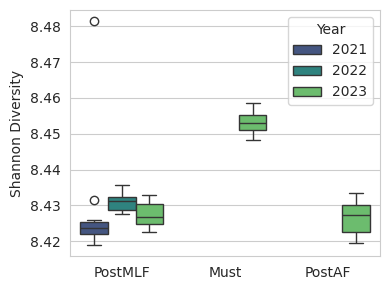

In [46]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [47]:
def richness(df):
    """Calculate richness (number of unique values) for each row in the DataFrame."""
    return df.apply(lambda x: x.nunique(), axis=1)

In [48]:
# Calculate richness for each sample (row)
richness_values = richness(df_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_wMetadata['sample_type'].values
richness_df['Year'] = df_wMetadata['year'].values

In [49]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 0.022086728758947752
ANOVA 2023 vs 2021 p-value: 0.7581568631293035
ANOVA 2022 vs 2021 p-value: 0.7286899108879314


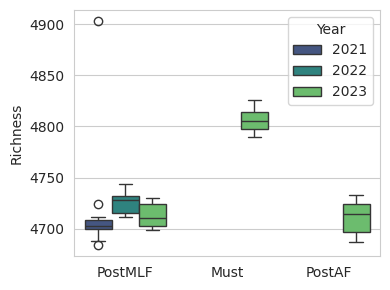

In [50]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [51]:
df_wMetadata.iloc[:, 4:] = np.log1p(df_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_wMetadata.iloc[:, 4:])

df_wMetadata.set_index('Sample Name', inplace=True)

In [52]:
df_wMetadata.shape

(52, 5067)

### Remove outliers

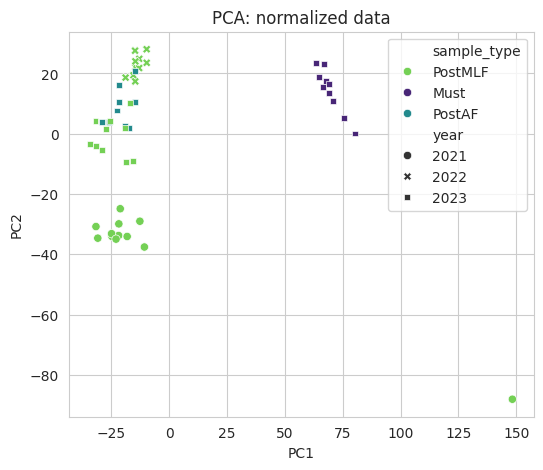

In [53]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata.iloc[:, 3:])

df_pca = df_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [54]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_wMetadata_cleaned = df_wMetadata[outlier_labels == 1]
df_wMetadata_cleaned.shape

(49, 5067)

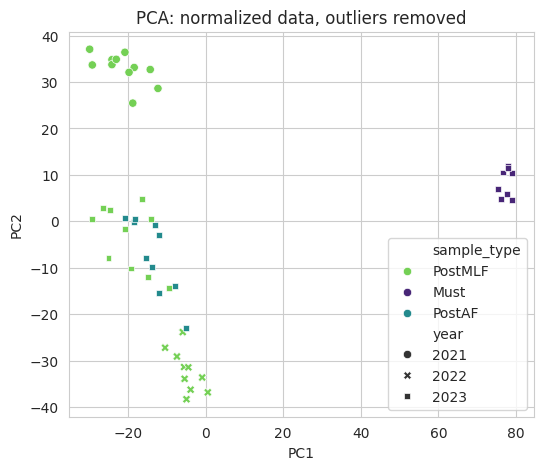

In [55]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, outliers removed')
plt.show()


In [56]:
# save
df_wMetadata_cleaned.to_csv('Neg_All_OutlierRemoved.csv')

# 3. Within 2023

In [57]:
duplicates = df_wMetadata_cleaned.columns[df_wMetadata_cleaned.columns.duplicated()]
print("Duplicate column names:", list(duplicates))


Duplicate column names: []


In [58]:
all_2023_df = df_wMetadata_cleaned[df_wMetadata_cleaned['year'] == '2023']
all_2023_df.head()

,sample_type,year,plot,(+)-abscisic acid beta-D-glucopyranosyl ester,(+)-applanatumol Z5,(+)-daeschol A,(+)-discoipyrrole A,(+)-pestalachloride E,(+/-)-Gingerol,(+/-)12(13)-DiHOME,...,tipifarnib,"trans,trans-Muconic acid",trans-Aconitic acid,trichloroacetate anion,tropatepine,vincofos,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
Sample Name,,,,,,,,,,,,,,,,,,,,,
Must_2023_Plot20,Must,2023,Plot20,1.311960,-0.675958,1.249946,0.838494,-1.476608,1.461841,-0.238020,...,2.430299,0.464867,-0.430664,1.075085,-0.735767,-0.565993,1.524452,2.274801,-0.259157,-0.471651
Must_2023_Plot19,Must,2023,Plot19,0.602026,-0.744163,1.051029,1.252196,-1.758096,0.892323,-0.383432,...,1.378214,0.452706,0.296038,1.110275,-0.792738,-0.600102,1.691644,1.137700,-0.267323,-0.213661
Must_2023_Plot14,Must,2023,Plot14,2.058819,-0.652459,2.247741,0.891567,-1.154488,1.023332,-0.306803,...,3.393581,2.139675,0.598717,0.942925,-0.722610,-0.772344,2.684261,2.092051,-0.202388,-2.260215
Must_2023_Plot17,Must,2023,Plot17,0.398220,-0.727703,1.458610,0.514691,-1.677318,1.181870,-0.362965,...,1.417043,0.718593,-0.218758,0.940092,-0.711553,-0.623636,1.136582,2.062054,-0.258848,-0.571928
Must_2023_Plot4,Must,2023,Plot4,1.166943,-0.744519,1.688399,2.224262,-1.255503,0.947170,-0.480625,...,2.522482,1.661336,0.667923,0.678432,-0.778723,-0.836800,1.742575,1.947283,-0.377432,-1.457317


In [59]:
# Separate features and target
X = all_2023_df.drop(['sample_type', 'year', 'plot'], axis=1)
y = all_2023_df['sample_type']

# Create a LabelEncoder object
le = LabelEncoder()
# Fit and transform the 'sample_type' column
y_encoded = le.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform OPLS-DA
pls = PLSRegression(n_components=2, scale=False)
X_opls = pls.fit_transform(X_scaled, y_encoded)[0]




In [60]:
# Calculate VIP scores
t = pls.x_scores_
w = pls.x_weights_
q = pls.y_loadings_

p, h = t.shape
vips = np.zeros((X.shape[1],))
s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
total_s = np.sum(s)
for i in range(X.shape[1]):
    weight = np.array([(w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h)])
    vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

# Get top discriminatory metabolites
top_n = 30  # Number of top metabolites to select
top_metabolites = X.columns[np.argsort(vips)[::-1][:top_n]]

/scratch/lfloerl/tmpdata/ipykernel_2446331/550795015.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vips[i] = np.sqrt(p*(s.T @ weight)/total_s)


In [61]:
# Perform one-way ANOVA
p_values = []
for metabolite in top_metabolites:
    groups = [group[metabolite].values for name, group in all_2023_df.groupby('sample_type')]
    f_value, p_value = f_oneway(*groups)
    p_values.append(p_value)

# Create a dataframe with top metabolites and their p-values
top_metabolites_df = pd.DataFrame({'Metabolite': top_metabolites, 'VIP': vips[np.argsort(vips)[::-1][:top_n]], 'p_value': p_values})
top_metabolites_df = top_metabolites_df.sort_values('VIP', ascending=False)

top_metabolites_df

,Metabolite,VIP,p_value
0,α-hydroxyacetovanillone,0.139314,3.283676e-16
1,2-O-ETHYL ASCORBIC ACID,0.138657,1.619090e-18
2,mz258.9811_RT0.27,0.137527,2.254297e-16
3,Macrosporin-7-O-sulphate,0.137283,4.237640e-16
4,mz399.9705_RT0.18,0.137205,1.736785e-16
5,mz399.9704_RT0.17,0.137097,2.069066e-16
6,mz233.9835_RT0.22,0.136329,5.213559e-21
7,mz395.9751_RT0.17,0.135416,3.078832e-13
8,L-Ascorbic acid 2-sulfate,0.134807,1.634756e-13
9,mz215.0538_RT0.26,0.134742,4.508360e-14


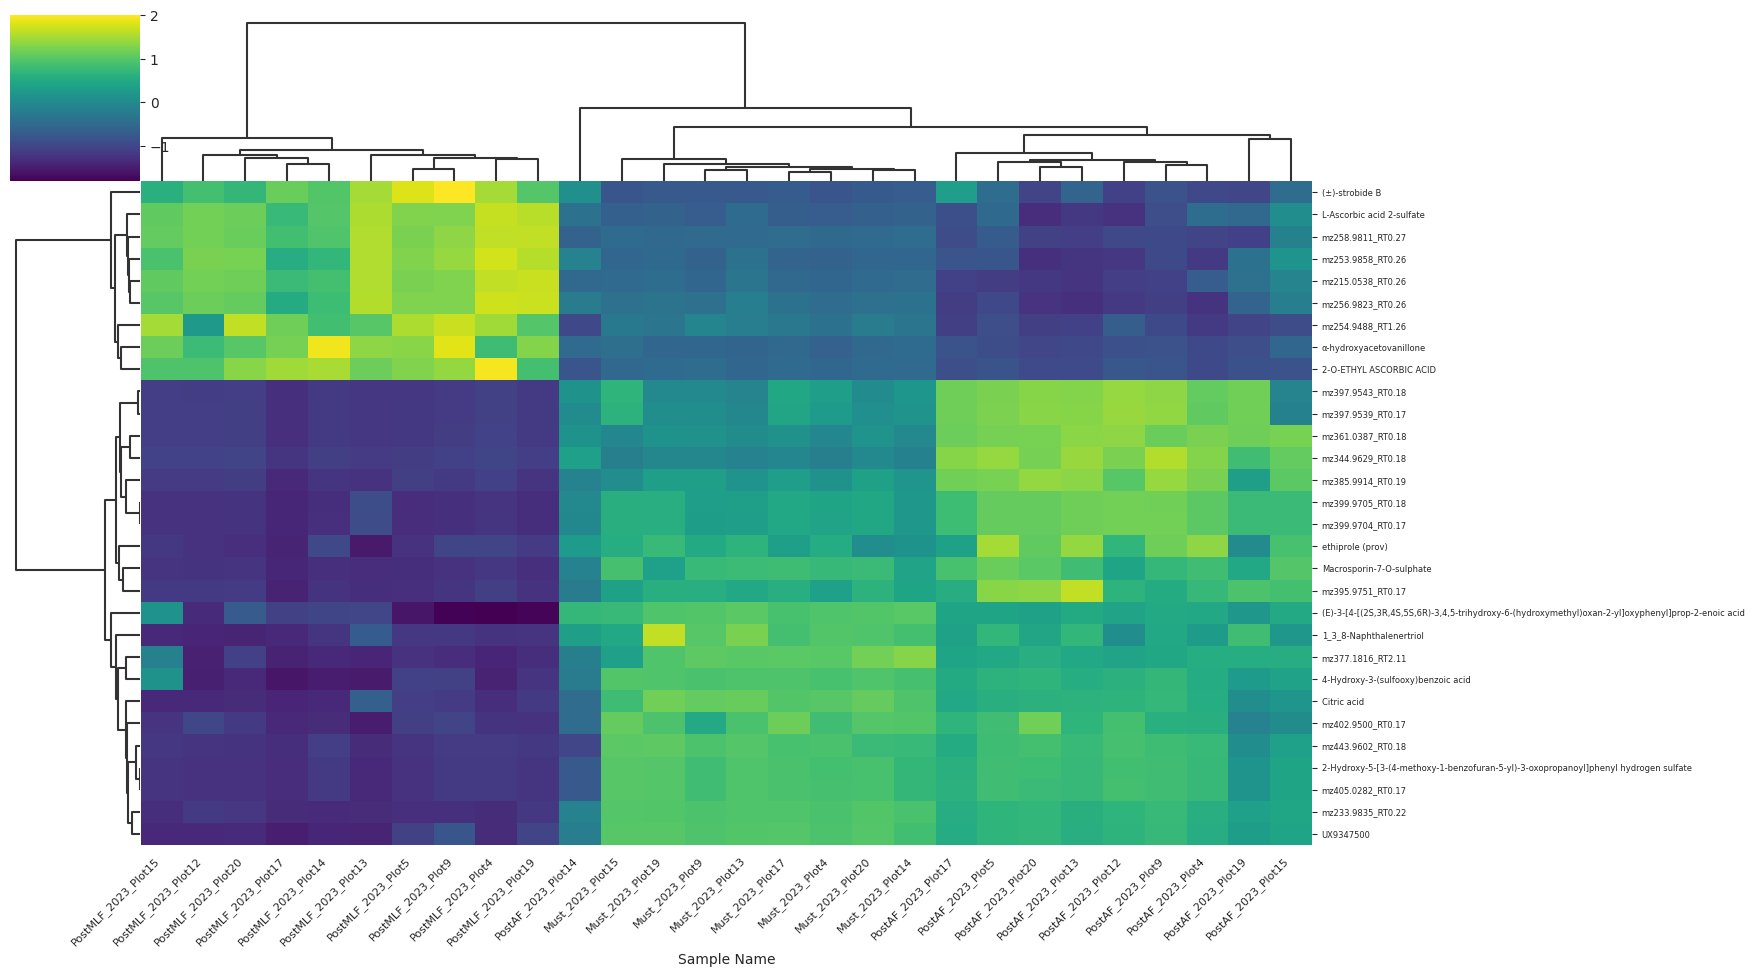

In [62]:
# Create heatmap data
heatmap_data = X[top_metabolites].copy()
heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()  # Z-score normalization

# Transpose the heatmap data
heatmap_data_transposed = heatmap_data.T

# Use in clustermap
g = sns.clustermap(heatmap_data_transposed, 
                   cmap='viridis', 
                   yticklabels=True, 
                   xticklabels=True, 
                   row_cluster=True,
                   col_cluster=True,
                   dendrogram_ratio=(0.1, 0.2),
                   cbar_pos=(1.8, .3, .03, .4),
                   tree_kws={'linewidths': 1.5},
                   figsize=(14, 10))

# Rotate x-axis labels and reduce font size
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# Reduce y-axis (metabolite) label font size
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)

# Adjust the layout
g.fig.subplots_adjust(top=0.93, bottom=0.1, left=0.05, right=0.98)

plt.show()
